In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from matplotlib import pyplot as plt
import time

Load Data:

In [2]:
df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
print(df.shape)

(225745, 79)


Clean cols + synthesize timestamps:

In [3]:
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.date_range(
    start="2017-07-07 15:00:00", periods=len(df), freq="10ms"
)
df = df.set_index('Timestamp')

In [4]:
df['packets'] = df['Total Fwd Packets'] + df['Total Backward Packets']
df['bytes']   = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']

# Keep robust & interpretable features
keep = [
    # Volume
    'packets',
    'bytes',

    # Port fan-out
    'Destination Port',

    # Size statistics
    'Packet Length Mean',
    'Packet Length Std',
    'Packet Length Variance',
    'Min Packet Length',
    'Max Packet Length',

    # TCP flags
    'SYN Flag Count',
    'ACK Flag Count',
    'FIN Flag Count',
    'RST Flag Count',
    'PSH Flag Count',
    'ECE Flag Count',

    # Subflow burstiness
    'Subflow Fwd Packets',
    'Subflow Bwd Packets',

    # Truth
    'Label',
]

df = df[keep]
df.head()

,packets,bytes,Destination Port,Packet Length Mean,Packet Length Std,Packet Length Variance,Min Packet Length,Max Packet Length,SYN Flag Count,ACK Flag Count,FIN Flag Count,RST Flag Count,PSH Flag Count,ECE Flag Count,Subflow Fwd Packets,Subflow Bwd Packets,Label
Timestamp,,,,,,,,,,,,,,,,,
2017-07-07 15:00:00.000,2,12,54865,6.0,0.0,0.0,6,6,0,1,0,0,0,0,2,0,BENIGN
2017-07-07 15:00:00.010,2,12,55054,6.0,0.0,0.0,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.020,2,12,55055,6.0,0.0,0.0,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.030,2,12,46236,6.0,0.0,0.0,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.040,2,12,54863,6.0,0.0,0.0,6,6,0,1,0,0,0,0,2,0,BENIGN


In [5]:
agg = df.resample("5s").agg({
    'packets':'sum',
    'bytes':'sum',
    'Destination Port':'nunique',

    'Packet Length Mean':'mean',
    'Packet Length Std':'mean',
    'Packet Length Variance':'mean',
    'Min Packet Length':'mean',
    'Max Packet Length':'mean',

    'SYN Flag Count':'sum',
    'ACK Flag Count':'sum',
    'FIN Flag Count':'sum',
    'RST Flag Count':'sum',
    'PSH Flag Count':'sum',
    'ECE Flag Count':'sum',

    'Subflow Fwd Packets':'sum',
    'Subflow Bwd Packets':'sum',

    'Label': lambda x: (x!='BENIGN').any()
})

In [6]:
agg['is_attack'] = (agg['Label'] != 'BENIGN').astype(int)
agg.drop(columns=['Label'], inplace=True)
agg.head()

,packets,bytes,Destination Port,Packet Length Mean,Packet Length Std,Packet Length Variance,Min Packet Length,Max Packet Length,SYN Flag Count,ACK Flag Count,FIN Flag Count,RST Flag Count,PSH Flag Count,ECE Flag Count,Subflow Fwd Packets,Subflow Bwd Packets,is_attack
Timestamp,,,,,,,,,,,,,,,,,
2017-07-07 15:00:00,27229,26893389,78,570.413784,633.420131,702460.221735,7.426,2202.764,29,130,22,0,272,0,12274,14955,1
2017-07-07 15:00:05,7935,4672920,3,100.970198,115.690112,51221.687179,35.342,400.142,9,33,0,0,87,0,3878,4057,1
2017-07-07 15:00:10,5454,1504141,4,124.247516,180.246743,99520.291746,23.676,608.718,7,50,0,0,158,0,2910,2544,1
2017-07-07 15:00:15,6242,3220935,228,115.277651,156.453320,120109.158421,9.670,523.802,50,306,2,0,103,0,3245,2997,1
2017-07-07 15:00:20,6855,2898138,5,132.322367,207.132379,123524.665054,19.418,720.558,9,75,4,0,178,0,3432,3423,1


In [7]:
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

In [18]:
Z_cols = ['packets','bytes','Destination Port']
zs = (agg[Z_cols] - agg[Z_cols].mean()) / agg[Z_cols].std()

# absolute deviation across dims
agg['z_score'] = zs.abs().sum(axis=1)

# threshold empirically (3 default → 2 for bursty traffic)
agg['z_anomaly'] = (agg['z_score'] > 0).astype(int)

In [19]:
ddos_features = [
    'packets',
    'bytes',
    'Packet Length Mean',
    'Packet Length Std',
    'SYN Flag Count',
    'ACK Flag Count',
    'FIN Flag Count',
    'RST Flag Count'
]

scaler = StandardScaler()
X = StandardScaler().fit_transform(agg[ddos_features])

IF = IsolationForest(
    contamination=0.06,   # lower contamination
    n_estimators=300,
    random_state=42
)
agg['if_anomaly'] = IF.fit_predict(X)

In [20]:
def metrics(name, pred):
    print(f"\n=== {name} ===")
    print("Precision:", precision_score(agg['is_attack'], agg[pred]))
    print("Recall:   ", recall_score(agg['is_attack'], agg[pred]))
    print("F1:       ", f1_score(agg['is_attack'], agg[pred]))


# baseline statistical
metrics("Z-Score", 'z_anomaly')

# ML:
metrics("IsolationForest (DDoS)", 'if_anomaly')



=== Z-Score ===
Precision: 1.0
Recall:    1.0
F1:        1.0

=== IsolationForest (DDoS) ===
Precision: 1.0
Recall:    0.9380530973451328
F1:        0.9680365296803652


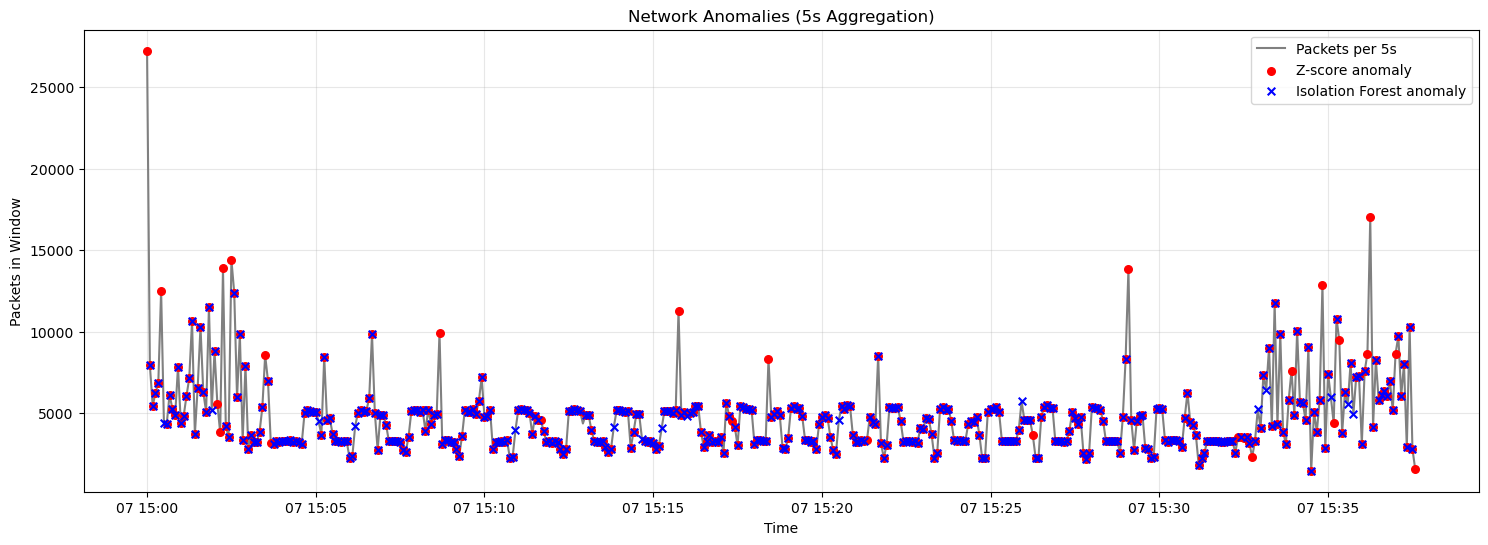

In [ ]:
plt.figure(figsize=(18,6))

plt.plot(
    agg.index,
    agg['packets'],
    color='grey',
    label='Packets per 5s'
)

plt.scatter(
    agg.index[agg['z_anomaly'] == 1],
    agg['packets'][agg['z_anomaly'] == 1],
    color='red',
    s=30,
    label='Z-score anomaly',
    zorder=3
)

plt.scatter(
    agg.index[agg['if_anomaly'] == 1],
    agg['packets'][agg['if_anomaly'] == 1],
    color='blue',
    s=30,
    marker='x',
    label='Isolation Forest anomaly',
    zorder=
)

plt.title("Network Anomalies (5s Aggregation)")
plt.xlabel("Time")
plt.ylabel("Packets in Window")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [17]:
print("\n=== Real-Time Anomaly Simulation ===\n")

for ts, row in agg.iterrows():
    if row['if_anomaly'] or row['z_anomaly']:
        print(
            f"[ALERT] {ts} | "
            f"packets={row['packets']} | "
            f"ports={row['Destination Port']} | "
            f"SYN={row['SYN Flag Count']} | "
            f"attack={row['is_attack']}"
        )
        time.sleep(0.05)


=== Real-Time Anomaly Simulation ===

[ALERT] 2017-07-07 15:00:00 | packets=27229.0 | ports=78.0 | SYN=29.0 | attack=1.0
[ALERT] 2017-07-07 15:00:05 | packets=7935.0 | ports=3.0 | SYN=9.0 | attack=1.0
[ALERT] 2017-07-07 15:00:10 | packets=5454.0 | ports=4.0 | SYN=7.0 | attack=1.0
[ALERT] 2017-07-07 15:00:15 | packets=6242.0 | ports=228.0 | SYN=50.0 | attack=1.0
[ALERT] 2017-07-07 15:00:20 | packets=6855.0 | ports=5.0 | SYN=9.0 | attack=1.0
[ALERT] 2017-07-07 15:00:25 | packets=12522.0 | ports=4.0 | SYN=16.0 | attack=1.0
[ALERT] 2017-07-07 15:00:30 | packets=4370.0 | ports=79.0 | SYN=30.0 | attack=1.0
[ALERT] 2017-07-07 15:00:35 | packets=4354.0 | ports=207.0 | SYN=55.0 | attack=1.0
[ALERT] 2017-07-07 15:00:40 | packets=6146.0 | ports=82.0 | SYN=34.0 | attack=1.0
[ALERT] 2017-07-07 15:00:45 | packets=5273.0 | ports=15.0 | SYN=24.0 | attack=1.0
[ALERT] 2017-07-07 15:00:50 | packets=4895.0 | ports=176.0 | SYN=39.0 | attack=1.0
[ALERT] 2017-07-07 15:00:55 | packets=7840.0 | ports=13.0 | S